In [1]:
# Imports das bibliotecas
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [2]:
# Dowload dos dados
!wget https://lazyprogrammer.me/course_files/spam.csv

--2024-11-02 17:54:41--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.02s   

2024-11-02 17:54:41 (19.6 MB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
# Instanciando o dataframe com a tabela de dados
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Dropando colunas inuteis
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [6]:
# Renomeando colunas para legibilidade
df.columns = ['labels', 'data']

In [7]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# Mapeando as classes para 0 e 1
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [9]:
# Separando os dados em teste e treino
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [10]:
df_train.shape, df_test.shape

((3733,), (1839,))

In [11]:
# Vocabulario maximo
MAX_VOCAB_SIZE = 20000
# Instancia do tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
# fit do tokenizer
tokenizer.fit_on_texts(df_train)
# Transforma o texto nas listas de inteiros
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [12]:
# Conta o numero de tokens
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'Found {V} unique tokens')

Found 7237 unique tokens


In [13]:
# Processa os dados adicionando padding e transformando em uma matriz
data_train = pad_sequences(sequences_train)
print(f'Shape of train data {data_train.shape}')
T = data_train.shape[1]

Shape of train data (3733, 189)


In [16]:
# Padding no set de teste
data_test = pad_sequences(sequences_test, maxlen=T)
print(f'Shape of test data {data_test.shape}')

Shape of test data (1839, 189)


In [17]:
# Criando o modelo
# Dimensionalidade do embedding
D = 20

# Layers da CNN
i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid',)(x)

# Instancia do modelo
model = Model(i, x)

In [18]:
# Compilando o Modelo
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [19]:
# Treinando o Modelo
r = model.fit(
    data_train,
    Ytrain,
    epochs=5,
    validation_data=(data_test, Ytest)
)

Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8589 - loss: 0.4632 - val_accuracy: 0.9560 - val_loss: 0.1545
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9718 - loss: 0.1023 - val_accuracy: 0.9837 - val_loss: 0.0539
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9865 - loss: 0.0334 - val_accuracy: 0.9880 - val_loss: 0.0421
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9986 - loss: 0.0095 - val_accuracy: 0.9897 - val_loss: 0.0441
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9997 - loss: 0.0030 - val_accuracy: 0.9880 - val_loss: 0.0488


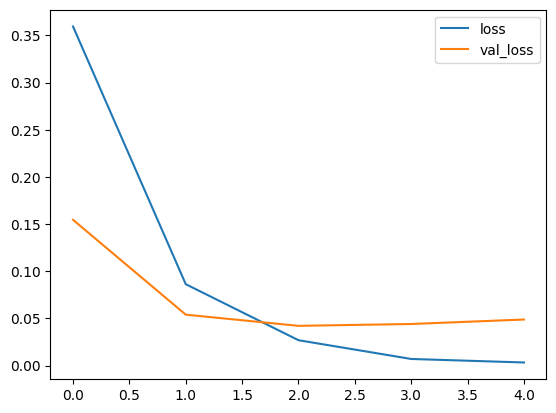

In [20]:
# Plots da função custo por iteração
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

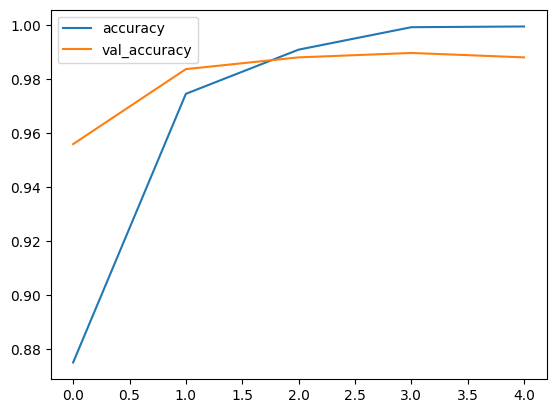

In [21]:
# Plots da precisão por iteração
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [23]:
# Atividade proposta, printar as frases equivocadas

# Utilzando os dados de teste no modelo já treinado
p_test = model.predict(data_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [58]:
# Reiniciando os indices do dataframe para evitar estouros na proxima
# celula
df_test = df_test.reset_index(drop=True)

In [63]:
# separa os dados onde a resposta não bateu
miss = np.where(p_test != Ytest)[0]
# Escolhe 1 aleatorio
i = np.random.choice(miss)

# Printa e redefine 0 e 1 para ham e spam
spam_ham = {0: 'ham', 1: 'spam'}

print(f"A frase '{df_test[i]}'\né na verdade um {spam_ham[Ytest[i]]}")


A frase 'As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune'
é na verdade um ham
